In [1]:
import re

First, define a function that accepts an open file handle corresponding to a GFF3 file, parses all gene features in it, then returns a dictionary of genes, keyed on the scaffolds they belong to.

In [2]:
def parse_gff3(handle):
    """Parse GFF3 file for gene information."""
    
    # Regex pattern to extract ID=... from attributes field
    id_pattern = re.compile('Name=([A-Za-z0-9|:._-]*)(?:;|$)')
    
    scaffolds = {}
    
    for line in handle:

        # Skip empty lines, or those starting with '#'
        if not line or line.isspace() or line.startswith('#'):
            continue
            
        (scaffold, _, feature, start, end, _, strand, _, attrs
        ) = line.strip().split('\t')
        
        # Skip non-gene features
        if feature != 'gene':
            continue
            
        # Save pertinent gene information
        gene = {
            'id': id_pattern.search(attrs).group(1),
            'strand': strand,
            'start': int(start),
            'end': int(end)
        }
        
        # Either create new scaffold, or append to old
        if scaffold not in scaffolds:
            scaffolds[scaffold] = [gene]
        else:
            scaffolds[scaffold].append(gene)
            
    return scaffolds

Now, open the GFF3 file, and pass the file handle to the function.

In [30]:
with open('cvic_reannotated.gff') as fp:
    scaffolds = parse_gff3(fp)

In [31]:
list(scaffolds)

['Cvic_tig01_p5',
 'Cvic_tig03_p5',
 'Cvic_tig05_p5',
 'Cvic_tig46_p5',
 'Cvic_tig08_p5',
 'Cvic_tig10_p5',
 'Cvic_tig12_p5',
 'Cvic_tig11_p5',
 'Cvic_tig17_p5',
 'Cvic_tig15_p5',
 'Cvic_tig16_p5',
 'Cvic_tig14_p5',
 'Cvic_tig18_p5',
 'Cvic_tig21_p5',
 'Cvic_tig25_p5',
 'Cvic_tig32_p5',
 'Cvic_tig34_p5',
 'Cvic_tig48_p5',
 'Cvic_tig23_p5',
 'Cvic_tig45_p5']

In [32]:
scaffolds[list(scaffolds.keys())[0]][:5]

[{'id': 'jgi.p|Cocvi1|21611', 'strand': '-', 'start': 1970864, 'end': 1971819},
 {'id': 'jgi.p|Cocvi1|11067', 'strand': '+', 'start': 1969716, 'end': 1970528},
 {'id': 'jgi.p|Cocvi1|83752', 'strand': '+', 'start': 1973505, 'end': 1974174},
 {'id': 'jgi.p|Cocvi1|21612', 'strand': '-', 'start': 1972513, 'end': 1973244},
 {'id': 'jgi.p|Cocvi1|83689', 'strand': '+', 'start': 1968827, 'end': 1969462}]

Now, define a function to compute the 5' and 3' intergenic distances of every gene in a scaffold.

In [33]:
def calculate_intergenic_distances(scaffold):
    """Compute 5' and 3' intergenic distances of every gene in a Scaffold"""
        
    # Sort all genes by start position
    scaffold = sorted(scaffold, key=lambda g: g['start'])
    dataset = []

    # Iterate all genes, offset at start and end
    for i in range(1, len(scaffold) - 2):
        
        # Get previous, current and next genes
        pre, cur, nex = scaffold[i-1:i+2]
        
        # Calculate intergenic distances (bp) each side
        five = cur['start'] - pre['end']
        three = nex['start'] - cur['end']
        
        # If reverse strand, make sure we switch 5/3 gaps
        if cur['strand'] == '-':
            three, five = five, three
            
        # Create new row corresponding to the current gene
        gene = [
            cur['id'],
            cur['strand'],
            five,
            three
        ]
            
        dataset.append(gene)
            
    return dataset

Now, calculate the 5' and 3' intergenic distances of every gene in the genome.

In [34]:
distances = [
    distance
    for genes in scaffolds.values()
    for distance in calculate_intergenic_distances(genes)
]

In [35]:
distances

[['jgi.p|Cocvi1|11534', '+', 900, 2010],
 ['jgi.p|Cocvi1|33106', '-', 3967, 2010],
 ['jgi.p|Cocvi1|84969', '+', 3967, 1987],
 ['jgi.p|Cocvi1|11532', '+', 1987, 1101],
 ['jgi.p|Cocvi1|22085', '-', 130, 1101],
 ['jgi.p|Cocvi1|11530', '-', 6912, 130],
 ['jgi.p|Cocvi1|33103', '-', 1532, 6912],
 ['jgi.p|Cocvi1|11528', '+', 1532, 355],
 ['jgi.p|Cocvi1|11527', '+', 355, 873],
 ['jgi.p|Cocvi1|84870', '+', 873, 1060],
 ['jgi.p|Cocvi1|11525', '+', 1060, 353],
 ['jgi.p|Cocvi1|84820', '-', 130, 353],
 ['jgi.p|Cocvi1|50819', '-', 736, 130],
 ['jgi.p|Cocvi1|22079', '-', 560, 736],
 ['jgi.p|Cocvi1|84724', '-', 1276, 560],
 ['jgi.p|Cocvi1|84933', '-', 1682, 1276],
 ['jgi.p|Cocvi1|84727', '-', 602, 1682],
 ['jgi.p|Cocvi1|84946', '+', 602, 968],
 ['jgi.p|Cocvi1|11519', '-', 356, 968],
 ['jgi.p|Cocvi1|22073', '+', 356, 524],
 ['jgi.p|Cocvi1|22072', '-', 1481, 524],
 ['jgi.p|Cocvi1|84812', '-', 608, 1481],
 ['jgi.p|Cocvi1|84832', '+', 608, 1780],
 ['jgi.p|Cocvi1|33088', '-', 1567, 1780],
 ['jgi.p|Cocvi1|3

Now we import numpy, pandas and matplotlib for generating the figure.

In [36]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize, stats
from numpy.polynomial import polynomial as P

%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib import cm, colors, style
from matplotlib.ticker import LogLocator, AutoLocator

style.use('default')

In [54]:
df = pd.DataFrame(distances, columns=['geneid', 'strand', 'five', 'three'])

In [55]:
df.shape

(12821, 4)

In [56]:
df[:10]

,geneid,strand,five,three
0,jgi.p|Cocvi1|11534,+,900,2010
1,jgi.p|Cocvi1|33106,-,3967,2010
2,jgi.p|Cocvi1|84969,+,3967,1987
3,jgi.p|Cocvi1|11532,+,1987,1101
4,jgi.p|Cocvi1|22085,-,130,1101
5,jgi.p|Cocvi1|11530,-,6912,130
6,jgi.p|Cocvi1|33103,-,1532,6912
7,jgi.p|Cocvi1|11528,+,1532,355
8,jgi.p|Cocvi1|11527,+,355,873
9,jgi.p|Cocvi1|84870,+,873,1060


Take the log of all IGDs, generate x/y bins in log space, then compute a 2d histogram using numpy. Then, draw a filled contour plot with log scales. When plotting genes of interest, we can directly plot their IGDs, rather than having to manually locate their bins.

In [62]:
def plot_histogram(df, ids=None, annotate=False, bins=60):
    """Use Gaussian kernel density estimator to colour scatter plot."""
    
    # Remove any values <= 0
    df = df[(df.five > 0) & (df.three > 0)]
    
    # Take log base 10 of all intergenic distances
    log_x, log_y = np.log10(df.five), np.log10(df.three)
    
    # Compute histogram bins, in log space, from lowest to highest distances
    x_bins = np.logspace(log_x.min(), log_x.max(), bins)
    y_bins = np.logspace(log_y.min(), log_y.max(), bins)
    
    # Generate histogram; this function swaps x and y
    histogram, *_ = np.histogram2d(df.three, df.five, bins=(y_bins, x_bins))
    
    # Define the colour map
    cmap = colors.LinearSegmentedColormap.from_list(
        'newCmap',
        [
            (1, 1, 1),
            (0, 0, 0.54),
            (0.13, 0.54, 0.13),
            (1, 0.75, 0.14),
            (1, 0.3, 0),
            (1, 0, 0),
            (0.54, 0, 0)
        ]
    )
    
    # Initialise the figure
    fig, ax = plt.subplots()
    ax.set_title('$\it{Cochliobolus}$ $\it{victoriae}$', fontsize='x-large')
    ax.set_xlabel("5' intergenic region (bp)")
    ax.set_ylabel("3' intergenic region (bp)")
    
    # Adjust axes
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(50, x_bins[-1])
    ax.set_ylim(50, y_bins[-1])
    
    # Filled contour plot
    cf = ax.contourf(
        x_bins[1:],
        y_bins[1:],
        histogram,
        levels=np.arange(histogram.max()),
        cmap=cmap
    )
    
    # Add colorbar
    cbar = fig.colorbar(cf)
    cbar.ax.set_ylabel('Number of genes')
    
    if ids:
        # Find genes in `ids` in dataframe
        rows = df[df.geneid.isin(ids)]

        # Plot them over the contour plot
        ax.scatter(
            rows.five,
            rows.three,
            c='white',
            edgecolors='black'
        )

        # Annotate the points
        if annotate:
            for index, row in enumerate(rows.itertuples()):
                ax.annotate(
                    row.geneid,
                    xy=(row.five, row.three),
                    xytext=(8000, 40 * np.exp(0.36 * index)),
                    fontsize=8,
                    arrowprops=dict(arrowstyle='-'),
                    bbox=dict(boxstyle="square", fc="w")
                )
        
    return cf

<IPython.core.display.Javascript object>


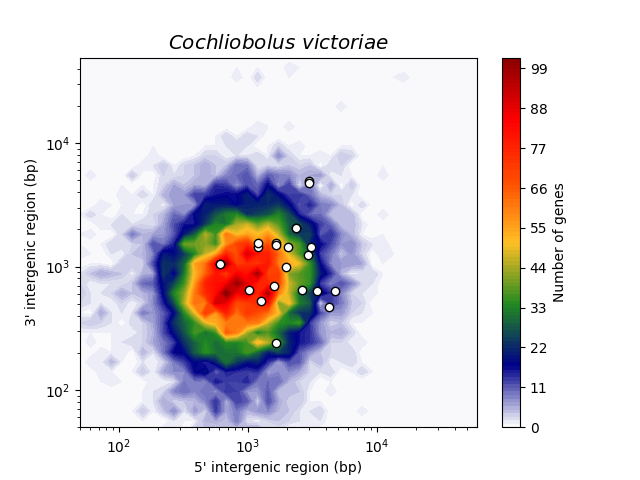

In [64]:
# IDs of effector genes
ids = [
  'jgi.p|Cocvi1|109554',
  'jgi.p|Cocvi1|21381',
  'jgi.p|Cocvi1|115485',
  'jgi.p|Cocvi1|117381',
  'jgi.p|Cocvi1|63600',
  'jgi.p|Cocvi1|21377',
  'jgi.p|Cocvi1|32336',
  'jgi.p|Cocvi1|117098',
  'jgi.p|Cocvi1|43172',
  'jgi.p|Cocvi1|117222',
  'jgi.p|Cocvi1|117222-2',
  'jgi.p|Cocvi1|116260',
  'jgi.p|Cocvi1|70699',
  'jgi.p|Cocvi1|116699',
  'jgi.p|Cocvi1|32336-2',
  'jgi.p|Cocvi1|117098-2',
  'jgi.p|Cocvi1|32161',
  'jgi.p|Cocvi1|116011',
  'jgi.p|Cocvi1|116867',
  'jgi.p|Cocvi1|117381-2',
  'jgi.p|Cocvi1|116826',
  'jgi.p|Cocvi1|21377-2',
  'jgi.p|Cocvi1|32336-3',
  'jgi.p|Cocvi1|117098-3'
]

cf = plot_histogram(df, ids)
plt.show()